<a href="https://colab.research.google.com/github/Ieef-msu/Deep-Learning/blob/main/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_1_%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D1%8B_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы нейронных сетей

*Автор: Сергей Артамонов*

##План лекции:

1. Некоторые проблемы линейных моделей
2. Перцептрон Розенблатта
3. Полносвязные нейронные сети
4. Виды современных нейронных сетей

В современной науке очень часто встречается задача приближения неких неизвестных функций и зависимостей по ограниченному набору наблюдений. Эти зависимости могут иметь совершенно разную природу и вытекать из постановок чисто практических прикладных задач. В некоторой степени эту задачу решают алгоритмы классического машинного обучения. Оказывается, существуют задачи, крайне плохо решаемые в рамках ограничений классического ML, что мотивирует нас рассматривать класс очень гибких, ёмких и достаточно сложных моделей, называемых **нейронными сетями**.

На этой лекции мы поговорим с вами о некоторых предпосылках появления нейронных сетей, обсудим историю их развития, а также интуицию и эвристики, на которые опирается наука о нейронных сетях.

## Линейные модели

В курсе классического машинного обучения вам приходилось неоднократно сталкиваться с классом **линейных моделей**. Линейные модели - это модели, использующие взвешенную сумму некоторых признаков для прогнозирования некоторой величины. Обучаемыми параметрами таких моделей выступают те самые веса, которые мы даём каждому признаку. Типичными представителями класса линейных моделей являются *обобщенный линейный классификатор*, *линейная регрессия*, *логистическая регрессия*, *метод опорных векторов*.

Условно линейную модель можно изобразить следующим образом:

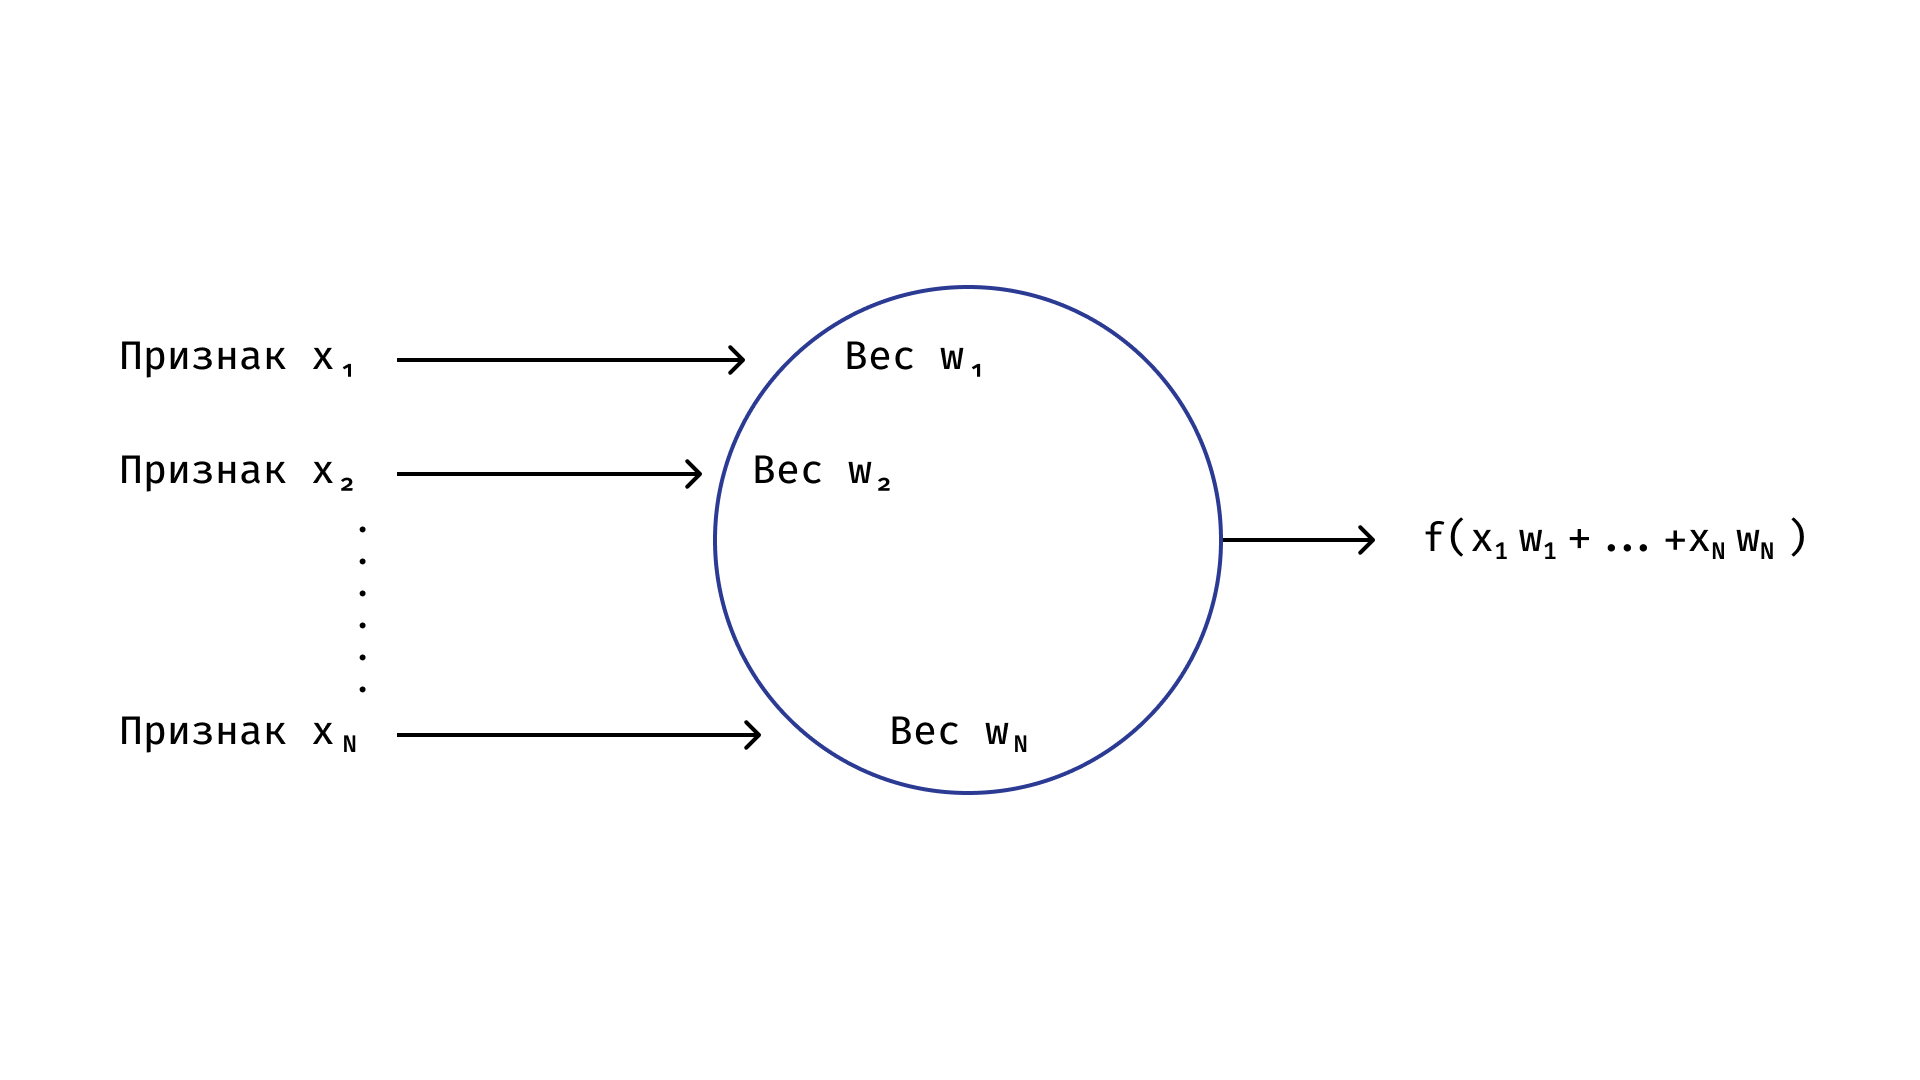

Линейные модели очень зависимы от структуры признакового пространства, на котором они построены. В рамках классического машинного обучения специалисты постоянно сталкиваются с необходимостью проведения серьезной предобработки признаков перед использованием их для построения линейных моделей. Например, вы наверняка сталкивались с понятием **линейной разделимости** выборки, то есть принципиальной возможности размеченной выборки быть безошибочно разделенной на 2 класса линейной гиперплоскостью. С этим свойством связана известная проблема линейных моделей, которая называется **XOR-problem**.

### XOR problem

Эта проблема связана с принципиальной невозможностью корректного разделения некоторых достаточно простых выборок на два класса при помощи линейных моделей. Например, речь может идти о следующей выборке:


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
rng = np.random.RandomState(0)

# зададим синтетический набор точек, состоящий из 4 кластеров
X1 = rng.randn(50, 2) + np.array([4,4])
X2 = rng.randn(50, 2) + np.array([-4,4])
X3 = rng.randn(50, 2) + np.array([4,-4])
X4 = rng.randn(50, 2) + np.array([-4,-4])
X = np.concatenate([X1,X2,X3,X4])
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

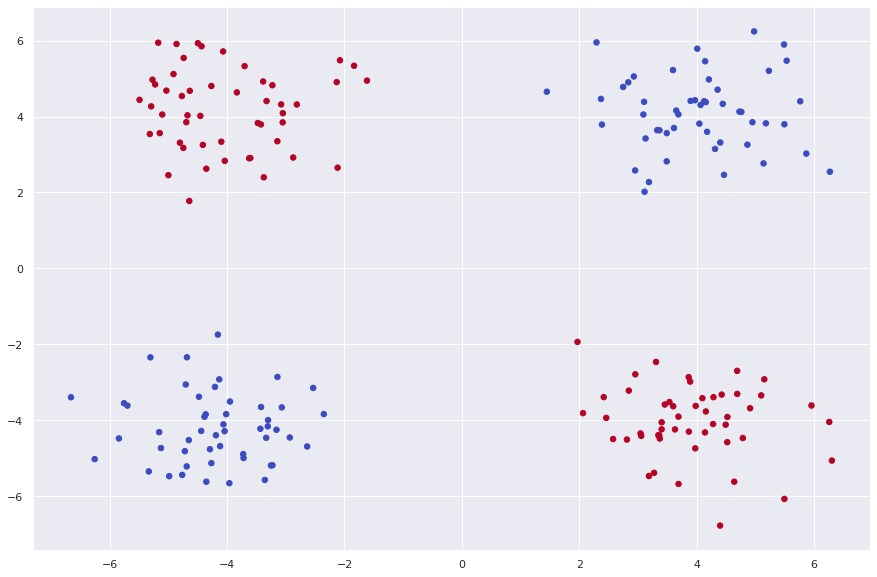

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.coolwarm);

Попробуем построить логистическую регрессию и изобразить интенсивность её выхода (то есть вероятности точки принадлежать классу "1" согласно предсказанию этой модели).

In [ ]:
def plot_boundary(clf, X, y, plot_title):
  """
  Функция для графического отображения интенсивности выхода линейной модели
  """
  x_mesh, y_mesh = np.meshgrid(np.linspace(-8, 8, 50), np.linspace(-8, 8, 50))
  clf.fit(X, y)
  Z = clf.predict_proba(np.vstack((x_mesh.ravel(), y_mesh.ravel())).T)[:, 1]
  Z = Z.reshape(x_mesh.shape)

  b1 = x_mesh.min()
  b2 = x_mesh.max()
  b3 = y_mesh.min()
  b4 = y_mesh.max()

  image = plt.imshow(Z, interpolation='nearest', extent=(b1, b2, b3, b4), aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
  contours = plt.contour(x_mesh, y_mesh, Z, levels=[0], linewidths=2, linetypes='--');
  plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.coolwarm)
  plt.xticks(())
  plt.yticks(())
  plt.axis([-8, 8, -8, 8])
  plt.colorbar(image)
  plt.title(plot_title, fontsize=20);

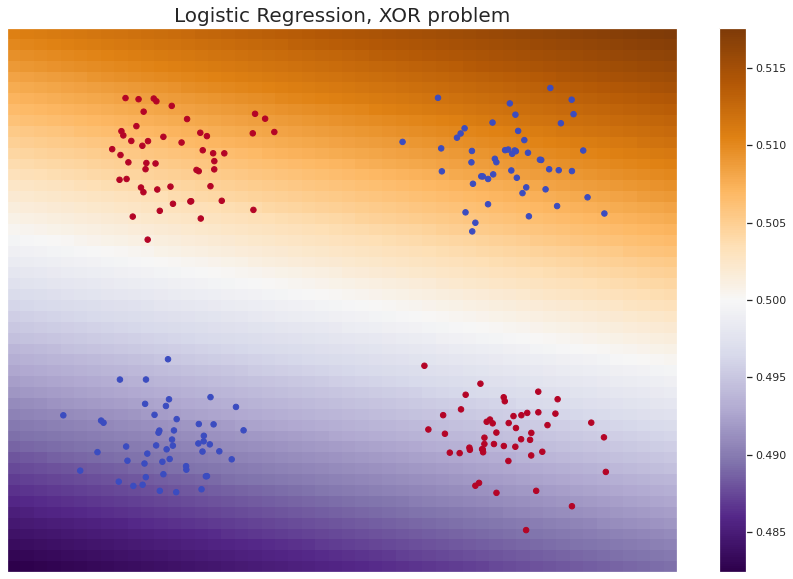

In [ ]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,10))
plot_boundary(LogisticRegression(), X, y,
"Logistic Regression, XOR problem")

## Высокоуровневые признаки

Модели машинного обучения ищут оптимальные способы извлечения информации из исходных признаков, описывающих объекты. Иногда мы можем "помочь" им, заранее сформировав более информативные и удобные для обработки признаки. Например, если мы хотим обучить модель предсказывать массу цилиндрического контейнера с молоком по нескольким прецедентам, мы можем подавать в качестве входных данных радиус основания цилиндрического контейнера и его высоту, а в качестве выхода такой модели ожидать точный прогноз массы такого бидона. Здравый смысл подсказывает нам, что функция, которую наша модель должна будет выучить, выглядит следующим образом:
$$m(h, r) = 3.14⋅r^2⋅h⋅ρ$$,
где $ρ$ - плотность молока.

Некоторые модели машинного обучения справятся с такой задачей, однако линейные модели теперь уже становятся неприменимы, да и остальные испытают ненужные сложности. Если же мы озаботимся формированием дополнительного признака - объёма контейнера - по хорошо известной нам формуле $V = 3.14⋅r^2⋅h$ и добавим его в вектор входных данных, любая модель с лёгкостью справится с этой задачей.

Существует целое направление в рамках науки о данных, которое занимается генерацией таких разумных дополнительных признаков. Признаки, полученные в рамках анализа, комбинирования и совмещения исходных признаков мы будем называть **высокоуровневыми**. В качестве подтверждения пользы формирования *высокоуровневых признаков* приведём также следующий пример.

Веса признаков линейной модели в некотором  смысле можно рассматривать как важность данного признака для принятия окончательного решения. Рассмотрим классический пример:

Пусть перед нами стоит задача оценки стоимости дома по описанию некоторых его характеристик. Скажем, эти признаки:

* число комнат,
* число ванных комнат,
* средний балл учеников в школах в округе (эту характеристику можно рассмаривать как оценку качества этих школ),
* процент озеленения территории района,
* станция метро,
* средняя стоимость жилья в районе.


Обычная линейная регрессия пытается сделать свое предсказание, основываясь на этих базовых признаках, данных нам. Но ведь некоторые комбинации этих признаков могут сказать нам намного больше, чем базовые признаки. Например: если мы знаем, сколько в доме комнат и сколько ванных, мы можем сказать, насколько он будет удобен для большой семьи. По информации о среднем балле в школах и проценте озеленения территории можно сделать вывод об удобстве данного района для воспитания детей. По станции метро и средней стоимости жилья можно узнать, насколько элитен район, в котором находится дом.

При помощи такого подхода мы можем сгенерировать признаковое описание **более высокого уровня**. Такие признаки лучше описывают наши объекты, как бы выделяя наиболее необходимую информацию из исходного описания. Как же можно эти признаки добыть?

Пусть нам нужно получить $M$ признаков высокого уровня по $N$ признакам низкого. Добиться этого можно при помощи обучения индивидуальной линейной регрессии для предсказания каждого из $M$ высокоуровневых признаков. Из полученных признаков можно создавать признаки все более и более высокого уровня, пока мы наконец не решим остановиться и обучить линейную регрессию, возвращающую нам итоговый ответ.


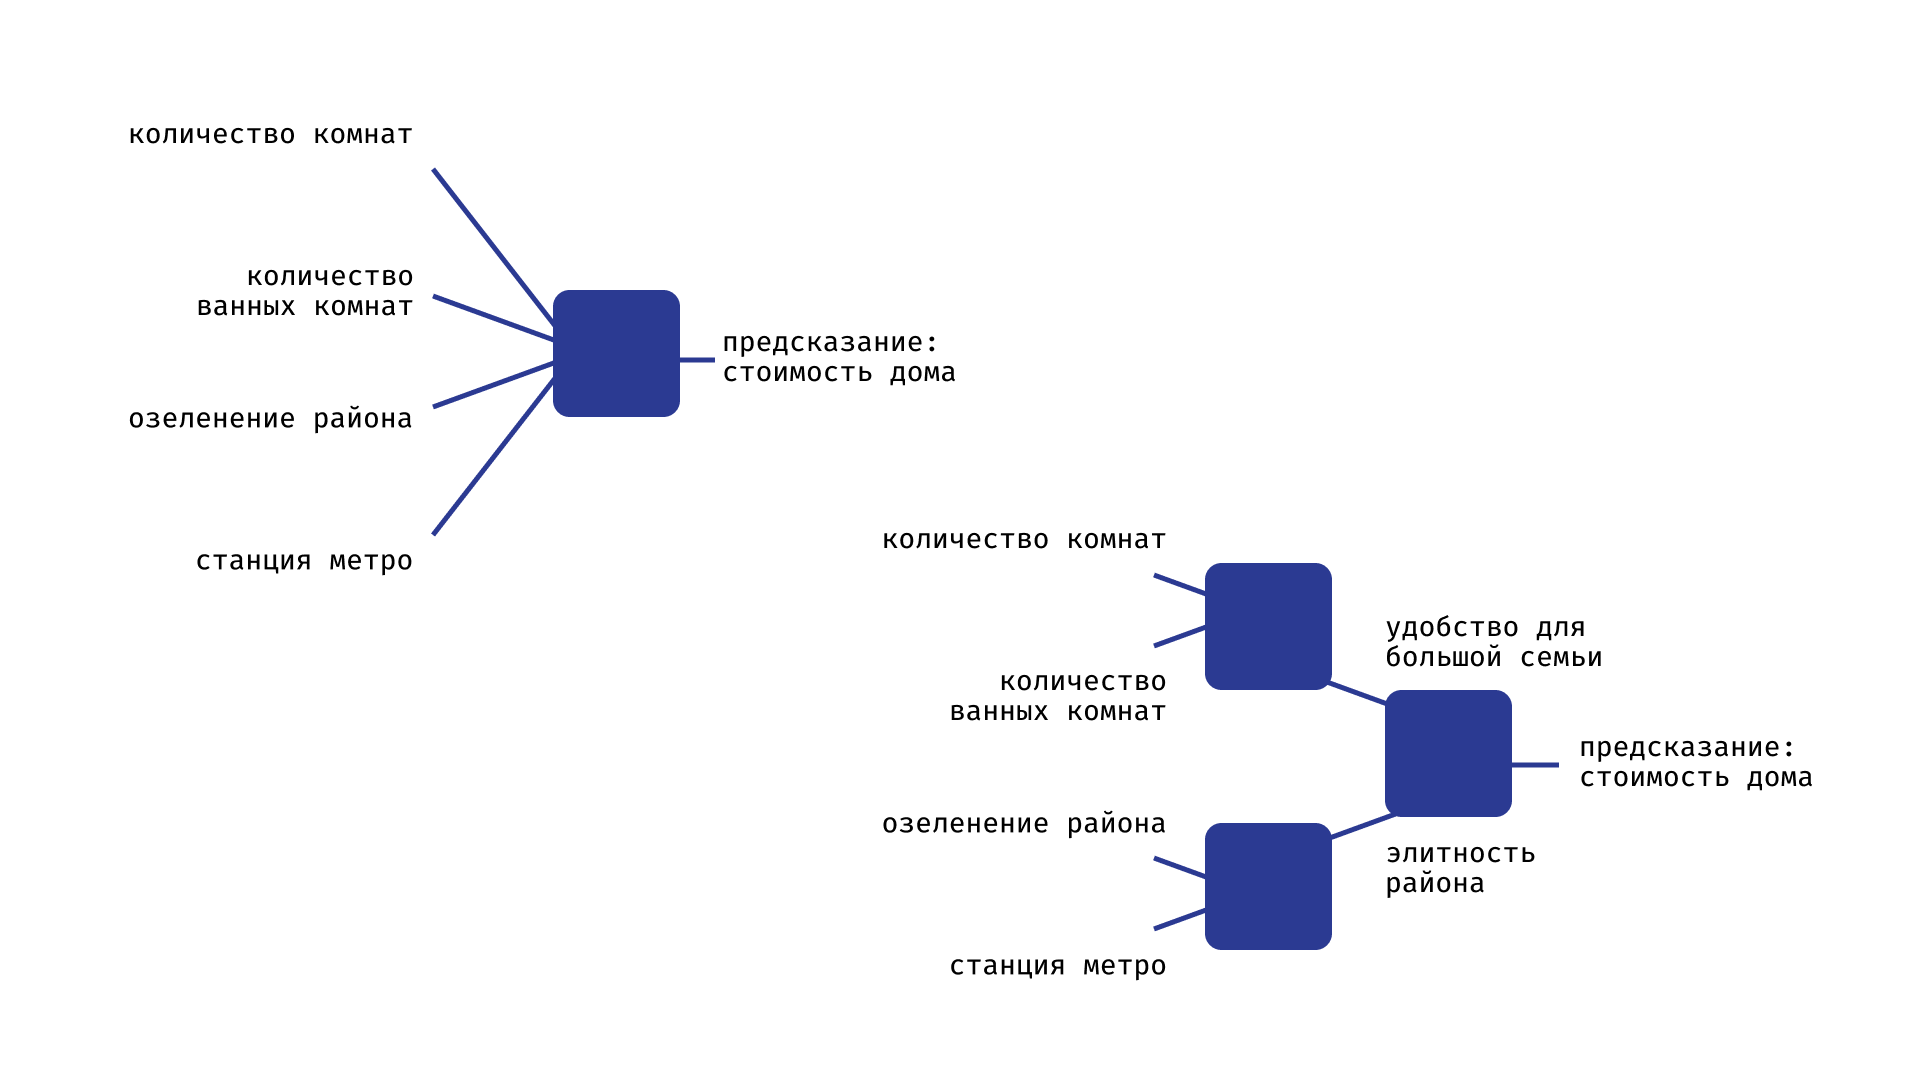

## Перцептрон Розенблатта

В 50-х годах XX века американский ученый Френк Розенблатт работал над математической моделью распознавания визуальных образов человеком.


В результате своих исследований Розенблатт пришел к следующим выводам:

* Распознавание объектов строится при помощи возбуждения некоторой комбинации сенсоров, которое в дальнейшем передается по нейронам.

* Нейрон представляет собой клетку, которая может находиться в одном из двух состояний: возбуждения и спокойствия. У нейрона есть N входных каналов, по которым к нейрону может передаться возбуждение, и один выходной канал, по которому нейрон может передать импульс дальше, на вход другим нейронам. Возбужденный нейрон передает импульс, спокойный - нет.

* Возбуждение нейрона достигается в том случае, если суммарный заряд, пришедший по входным каналам, превышает некоторый порог

* Нейроны связаны друг с другом в 3 слоя: первый слой - сенсорный, он принимает возбуждение отдельных рецепторов, пришедшее из окружающей среды. Второй - скрытый, функционирует по указанному механизму. Третий слой - распознающий. Он состоит из N нейронов, каждый из которых может быть либо возбужден, либо спокоен. Каждый из нейронов отвечает некоторому образу, а факт возбуждения этого нейрона - определению данного образа

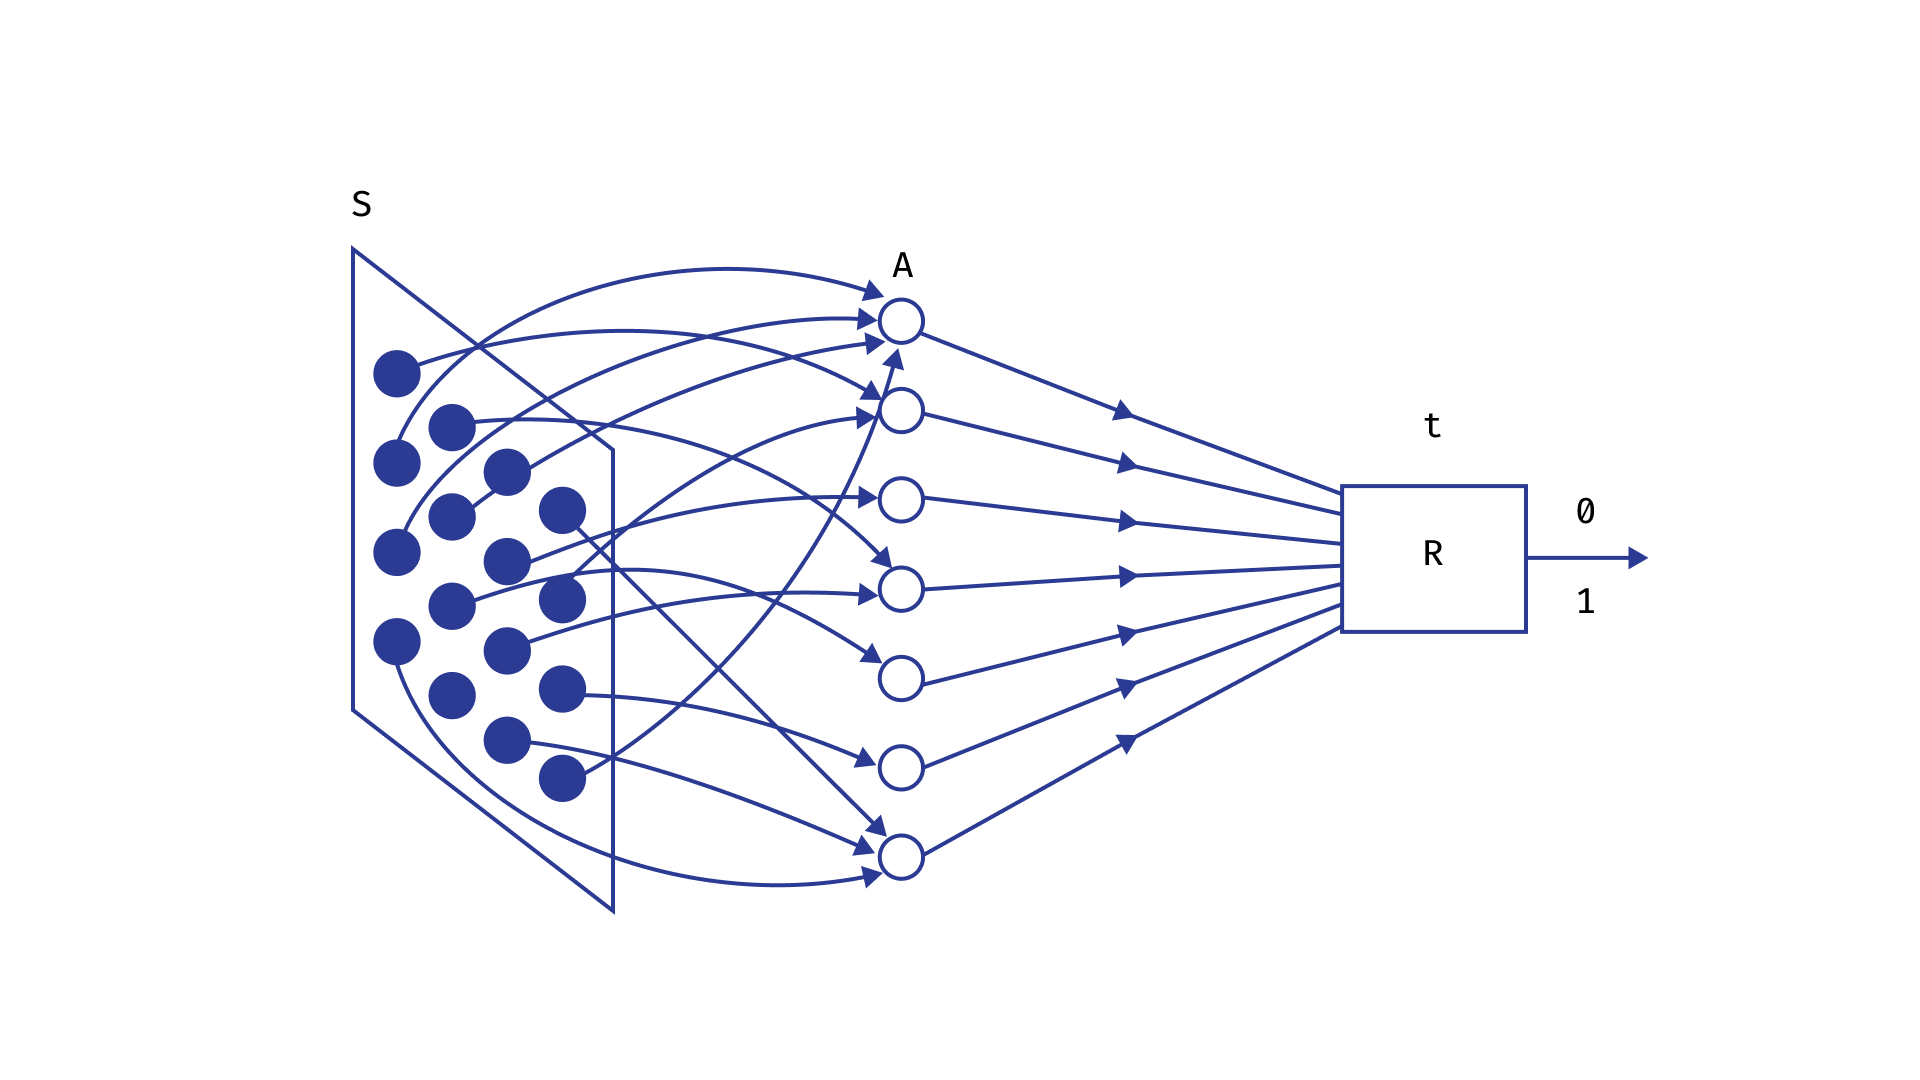

__________________________________________
Работа одного нейрона в этой парадигме очень напоминает функционирование линейной регрессии с некоторым уточнением.

Пусть $λ_i$ - это сигнал, пришедший на i-й входной канал нашего нейрона. Тогда выходной сигнал определяется как $$output(\vec{λ}) = [∑λ_i > β]$$ где β - пороговое значение **активации** данного нейрона (то есть порог заряда, начиная с которого нейрон переходит в состояние возбуждения).

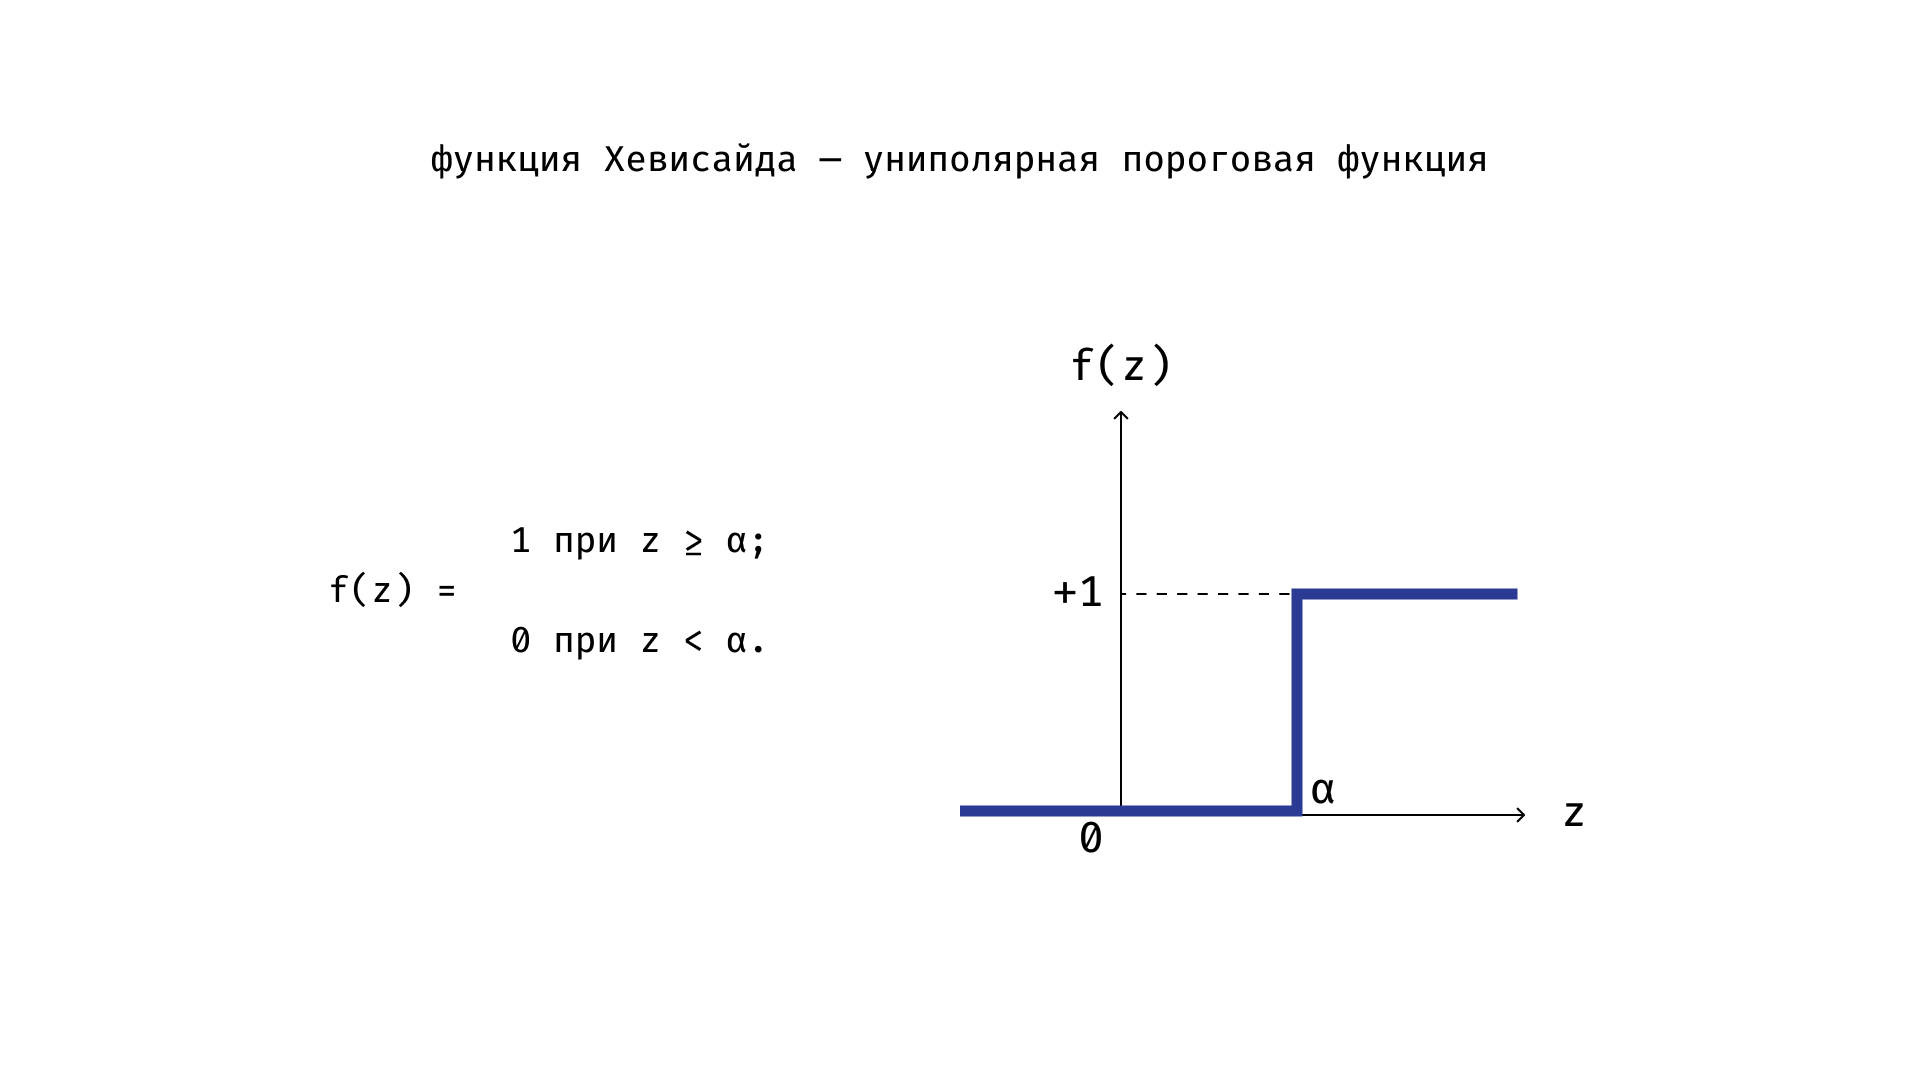

Заметим две детали, отвечающие нашему восприятию физики данного процесса.

Во-первых, каждый входной и выходной канал каждого нейрона, вероятно, обладает своим собственным сопротивлением, влияющим на передаваемый по каналу импульс. Смоделировать этот процесс мы можем при помощи введения **весов** для каждого из входных импулльсов. То есть output($\vec{λ}$) = [∑$w_iλ_i$ > β], где $w_i$ - это вес, характеризующий сопротивление i-го входного канала



Во-вторых, вряд ли настоящие нейроны действительно так категоричны в распространении электрического импульса, что имеют всего 2 состояния: 0 и 1. Скорее всего, нейрон всегда передает некий импульс на следующие слои, просто этот импульс сильно зависит от указанной входной суммы импульсов. График этой выходной функции скорее всего довольно сильно должен быть похож на пороговую функцию. Возможно, кто-то из вас уже догадался, что хорошим примером такой функции может служить известная нам сигмоида.

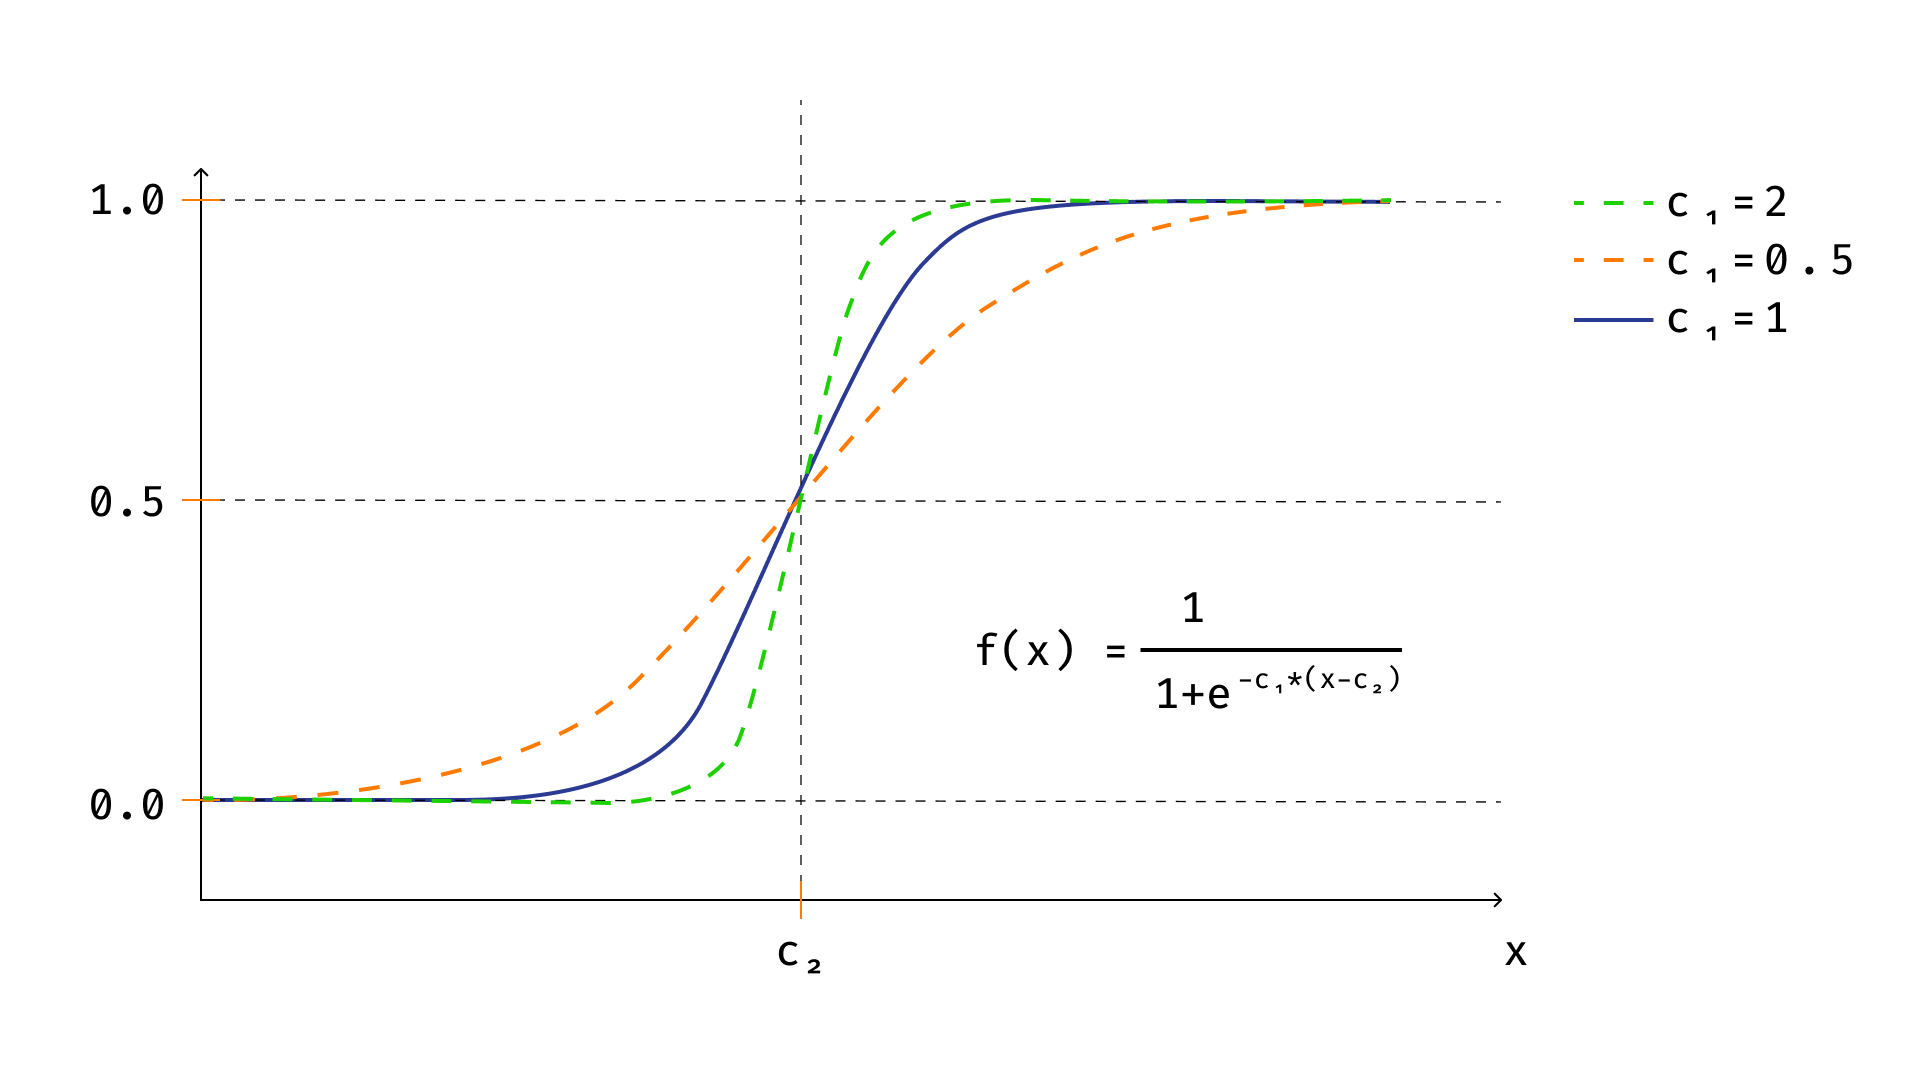



Если мы заменим пороговую функцию на сигмоидальную, математическая модель нашего нейрона превратится окончательно в модель логистической регрессии. Действительно, $$output(\vec{λ}) = σ(∑w_iλ_i)$$

В общем случае на месте сигмоиды могут стоять и некоторые другие функции. Такие функции называются **функциями активации**. Классическими примерами функции активации служат гиперболический тангенс, линейная функция, функция relu.

### Решение XOR-problem

На основе идеи выделения высокоуровневых признаков мы очень просто находим решение описанной выше проблемы.

Попробуем объединить три логистические регрессии в следующую конструкцию:

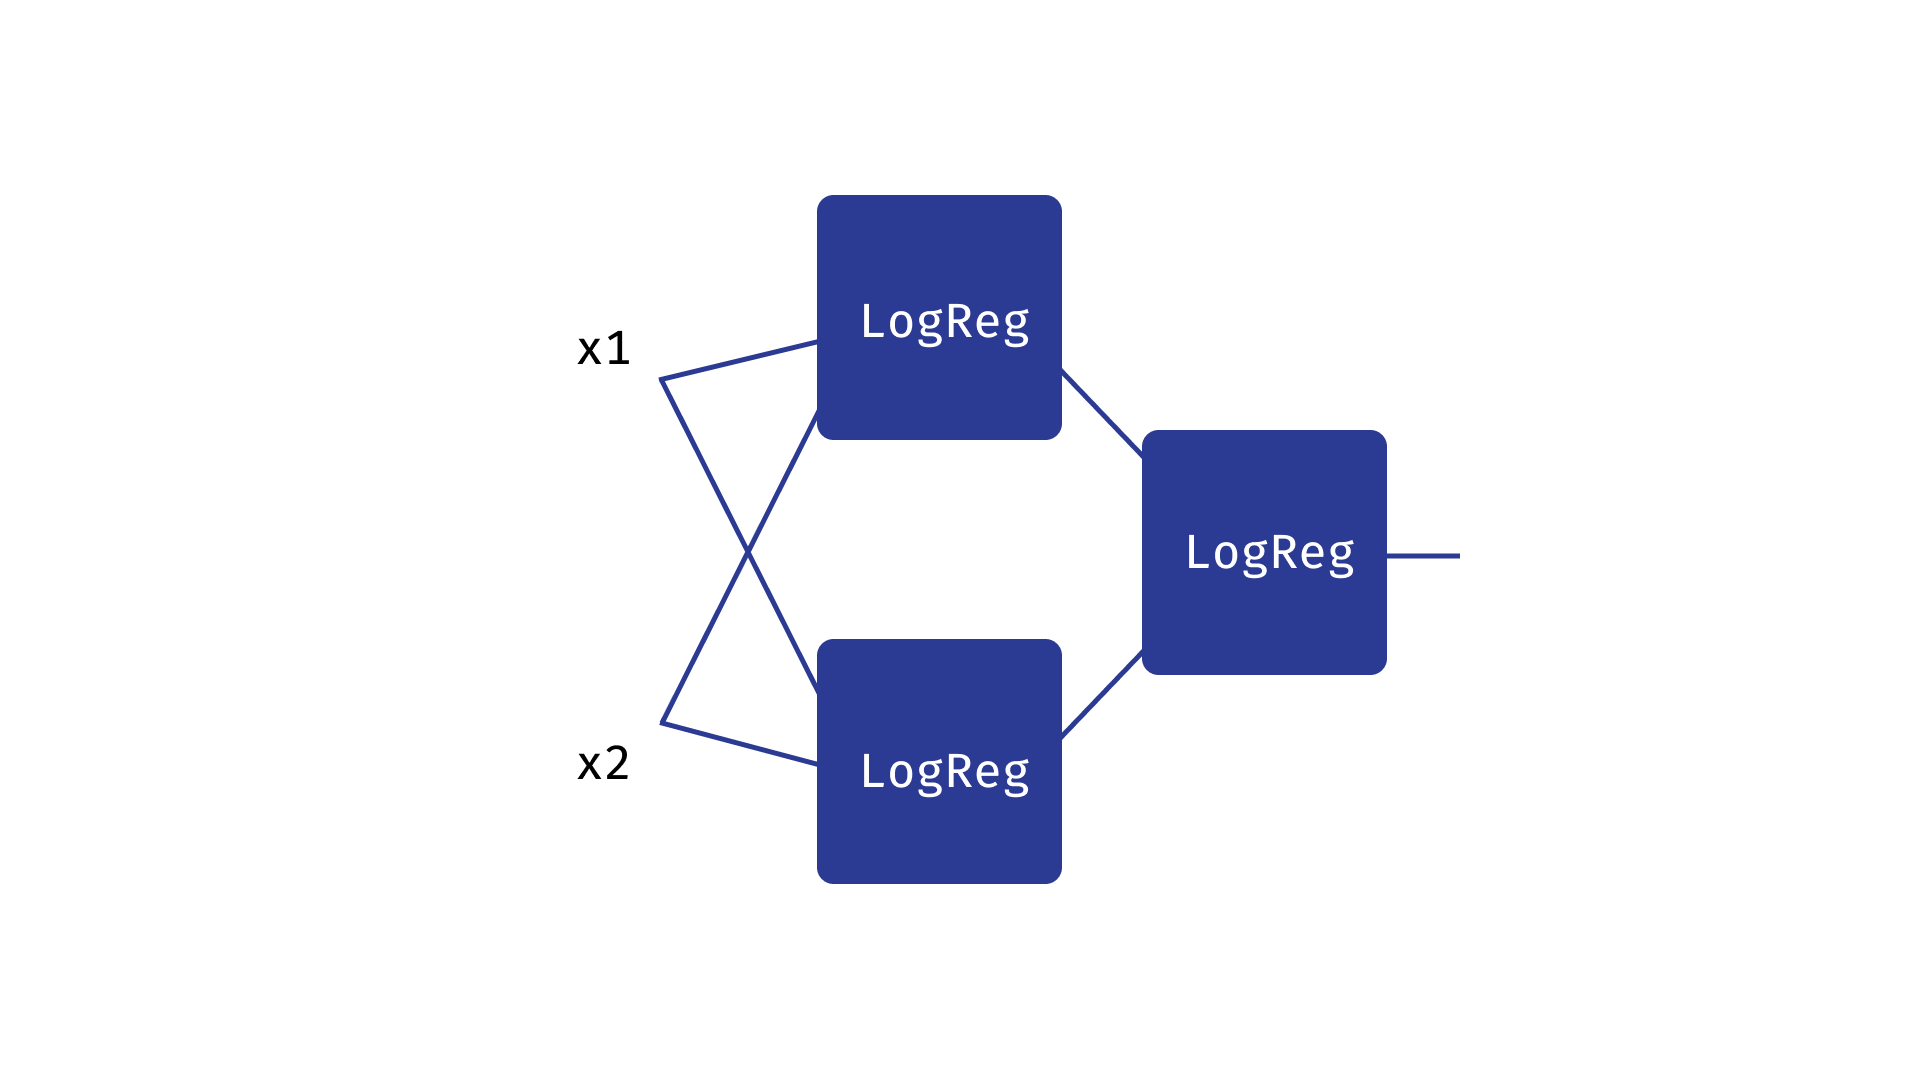



Заметим следующие детали:

1) То, что мы получили, является объединением трех логистических регрессий, которые могут извлекать высокоуровневые признаки и использовать их для окончательного предсказания.

2) Такая структура напоминает комбинацию трех нейронов в модели Розенблатта.

3) Мы можем рассчитывать, что построенные на первом уровне логистические регрессии будут отвечать первичному разделению плоскости на 3 класса, в то время как окончательная логистическая регрессия объединит их предсказания воедино.

In [ ]:
class trinity_of_lr:
  def __init__(self):
    # Инициализируем 3 логистические регрессии
    self.lr_1 = LogisticRegression()
    self.lr_2 = LogisticRegression()
    self.lr_3 = LogisticRegression()

  def fit(self, X, y):
    # Обучим их предсказывать принадлежность точки некоторой подобласти
    # Эти подобласти мы пока что выберем сами
    # В будущем мы будем строить модели, определяющие эти подобласти самостоятельно
    y_1 = (X[:,0] > 0).astype(int) * (X[:,1] < 0).astype(int)
    y_2 = (X[:,0] < 0).astype(int) * (X[:,1] > 0).astype(int)

    self.lr_1.fit(X,y_1)
    self.lr_2.fit(X,y_2)

    probas_1 = self.lr_1.predict_proba(X)
    probas_2 = self.lr_2.predict_proba(X)

    x_3 = np.concatenate([probas_1, probas_2], axis=-1)

    self.lr_3.fit(x_3,y)

  def predict(self, X):
    # Предсказания первых двух моделей используем для формирования предсказания третьей
    probas_1 = self.lr_1.predict_proba(X)
    probas_2 = self.lr_2.predict_proba(X)
    x_3 = np.concatenate([probas_1, probas_2], axis=-1)

    preds = self.lr_3.predict(x_3)
    return preds


  def predict_proba(self, X):
    probas_1 = self.lr_1.predict_proba(X)
    probas_2 = self.lr_2.predict_proba(X)
    x_3 = np.concatenate([probas_1, probas_2], axis=-1)

    preds = self.lr_3.predict_proba(x_3)
    return preds

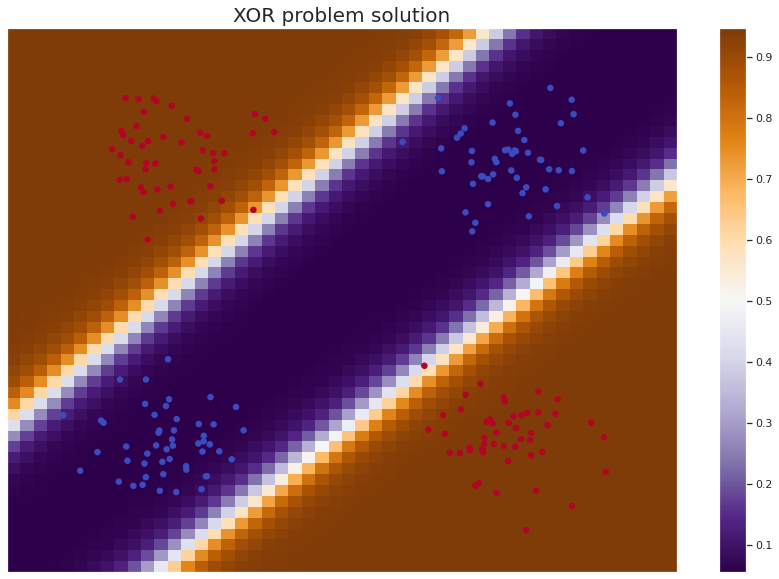

In [ ]:
plt.figure(figsize=(15,10))
plot_boundary(trinity_of_lr(), X, y,
"XOR problem solution")

## Полносвязные нейронные сети

Теперь мы вплотную подошли к тому чтобы дать определение классических **полносвязных нейронных сетей**. Сначала дадим определение, а затем подробно обсудим его и найдём связь такого определения со структурой комбинирования логистических регрессий, которую мы обсудили выше.

**Определение**. Полносвязной однослойной нейронной сетью с N нейронами мы будем называть функцию векторного аргумента $\vec{x}$ ($\vec{x}$ - вектор-столбец), параметризованную матрицей параметров $W = (w_{ij})$, имеющую следующий вид: $$NN(\vec{x}) = f(W⋅\vec{x} + B)$$
Матрица W здесь имеет размерность $N \times dim(\vec{x})$. Функция f здесь - произвольная функция, которая называется **функцией активации**.

**Замечание:** в дальнейшем мы иногда будем опускать слагаемое  $B$, потому что действие добавления $B$ эквивалентно формальному добавлению к матрице $X$ столбца из единиц. В этом случае к параметрам $W$ в каждом нейроне добавляется еще одна компонента, которая при умножении на тот самый столбец единиц моделирует добавление этого слагаемого.

### Связь нейронных сетей с комбинированием линейных моделей

В нашем примере с 3 логистическими регрессиями мы могли не останавливаться на такой простой модели. У нас есть целых 2 степени свободы: во-первых, мы могли бы увеличить число первичных линейных моделей. Например, взять не 2 логистические регресси, а 3, 4, 10, 100, сколько бы мы ни захотели. В будущем мы будем называть каждую отдельную линейную модель вместе с нелинейной функцией (например, для логистической регресси это сигмоида) **нейроном**. Нужно отметить, что в нейроне вместо сигмоиды может стоять произвольная в общем случае нелинейная функция, от которой мы требуем лишь дифференцируемости почти всюду. Комбинацию же параллельных нейронов мы будем называть **слоем**. Отсюда берётся вторая степень свободы - мы могли бы *увеличить количество слоёв*, то есть сделать так, чтобы признаки, полученные на выходе работы первого слоя, шли на вход второму, выходы второго - на вход третьего и так далее.

В итоге мы бы получили такую картинку:

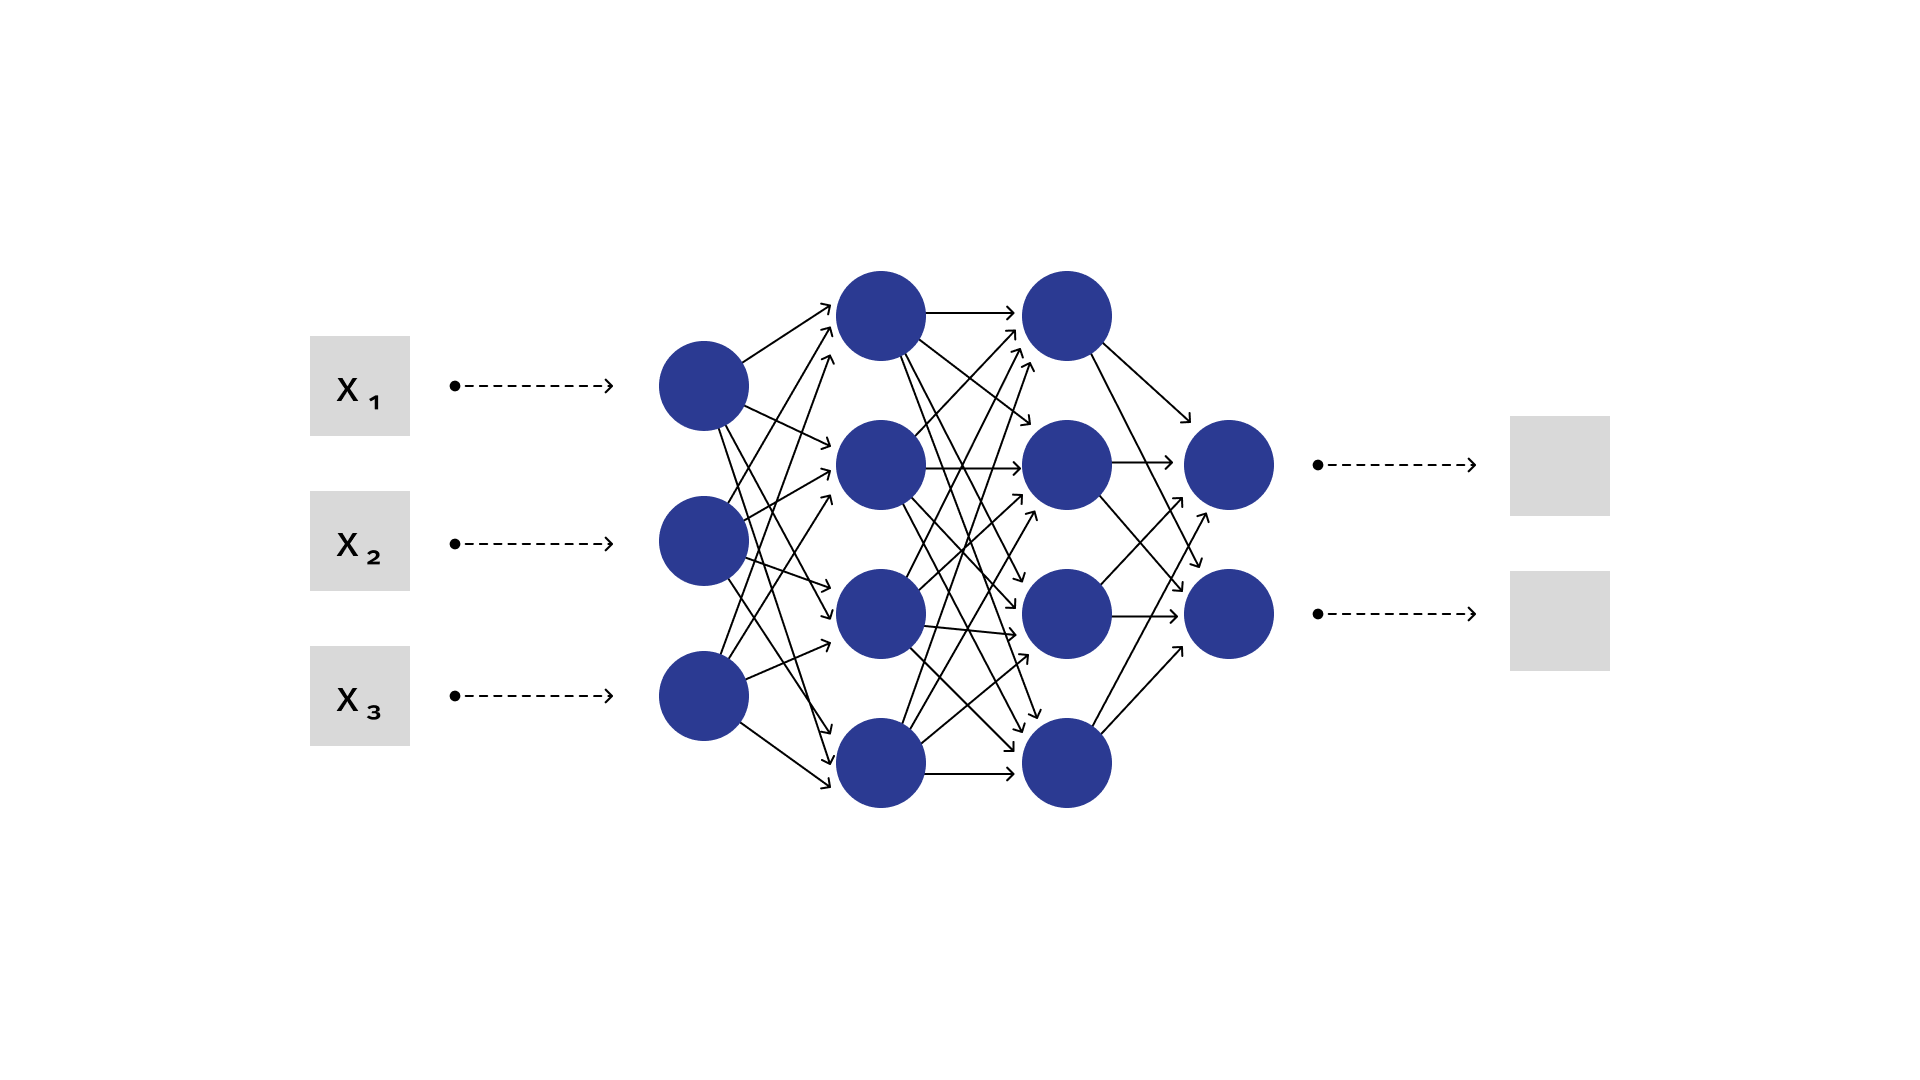

Если всё же рассмотреть всего лишь один слой, мы сможем выписать уравнения связи входа и выхода этого слоя в матричном виде:

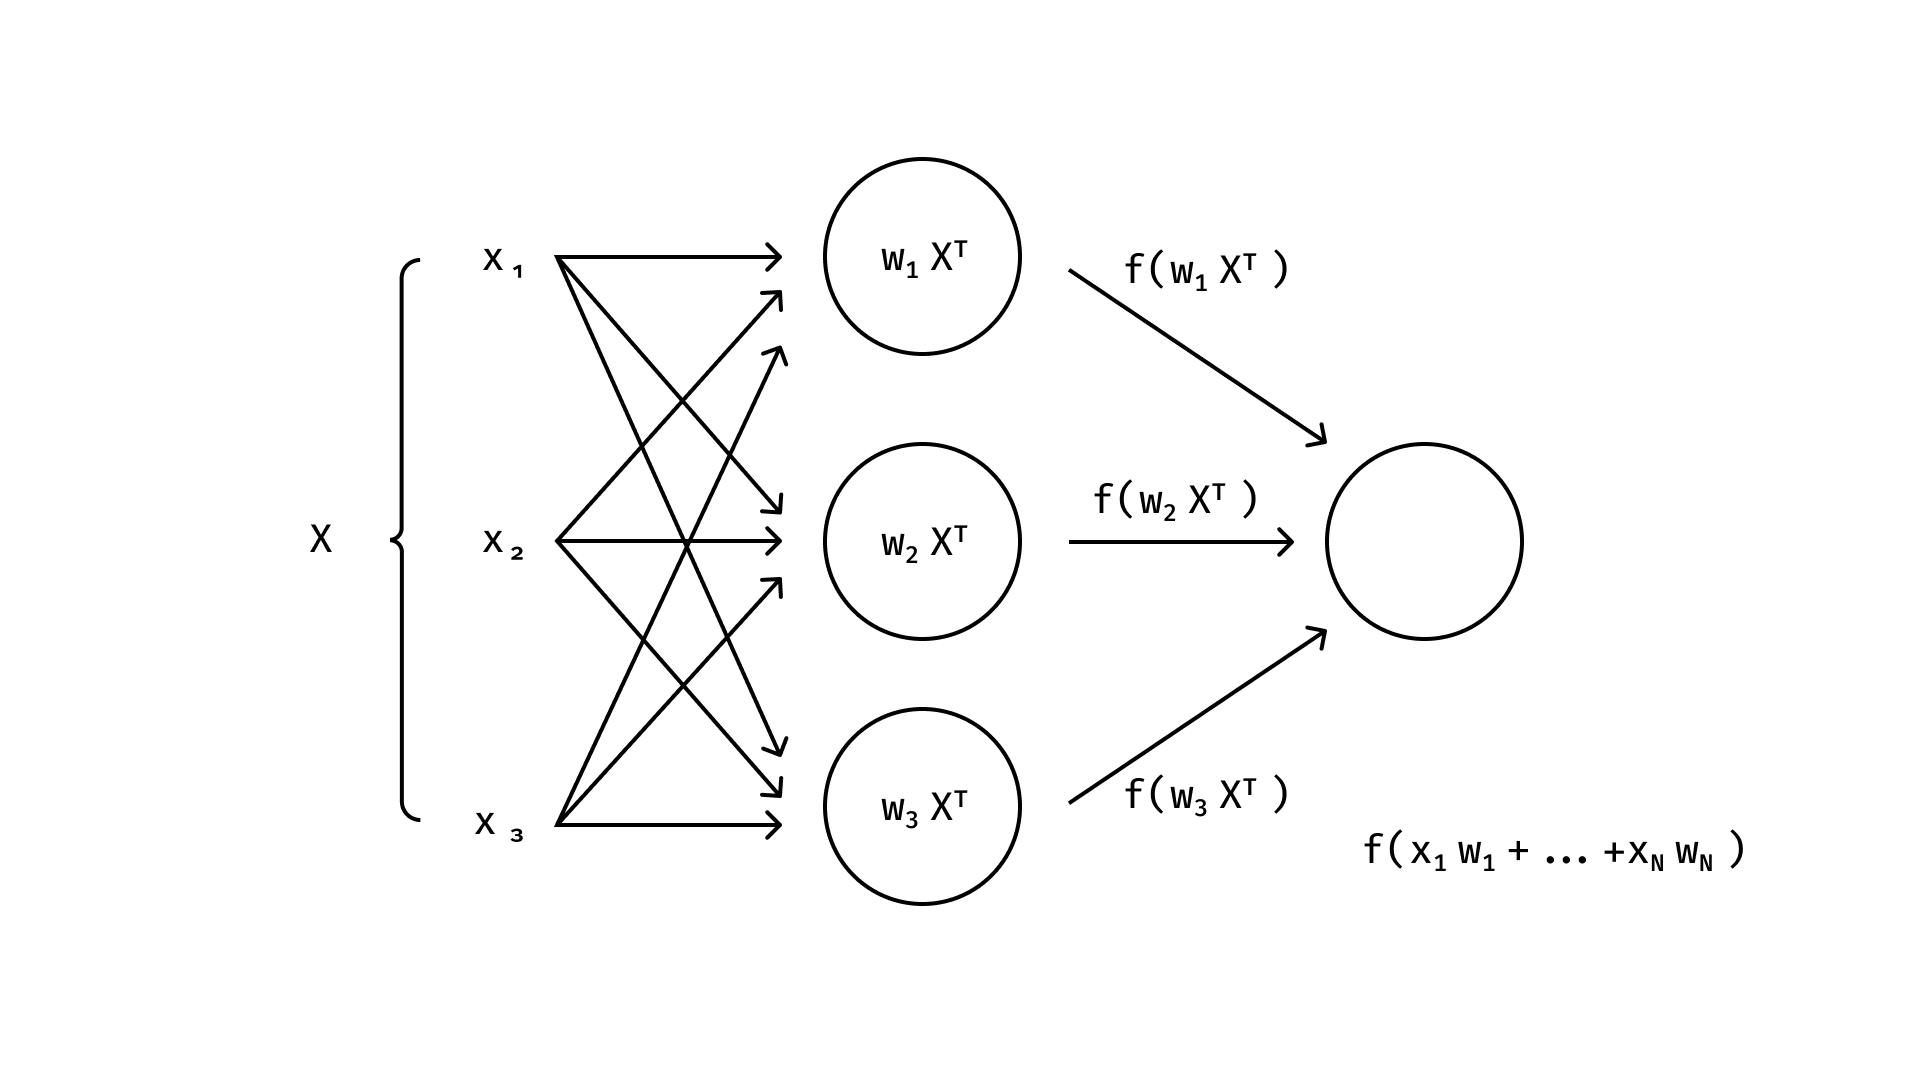

В рамках каждого из этих параллельных преобразований мы скалярно умножаем некоторый вектор весов $\vec{w}_i$ на один и тот же входной вектор $\vec{x}$, то есть полученный набор чисел имеет вид $((\vec{w}_1, \vec{x}) ... (\vec{w}_N, \vec{x}))$. Задумаемся вот над чем:  если мы запишем все векторы $\vec{w}_i$ в одну матрицу построчно, то по правилам матричного умножения $W⋅\vec{x}$ будет вектор-столбец, размерности $N × 1$. Компонента с индексом i этого выходного вектора будет представлена скалярным произведением i-й строки матрицы W на $\vec{x}$, то есть $(\vec{w}_i, \vec{x})$. Значит, чтобы получить выход представленного слоя достаточно рассмотреть набор чисел, который получается в результате матричного произведения $W⋅\vec{x}$.

На самом деле тот же самый результат можно получить в результате вычисления выражения $\vec{x}⋅W$, но лишь в том случае, когда вектор $\vec{x}$ представлен вектором-строкой, а векторы $w_i$ записаны в матрицу W не построчно, а *по столбцам*. Этот вывод очень просто получить, расписав матричное произведение покомпонентно в том и другом случае.

Остается последний шаг - применение функции активации $f$. То есть на выходе мы получим вектор $(f(\vec{w}_1, \vec{x}) ... f(\vec{w}_N, \vec{x}))$. Ради краткости, применение функции $f$ отдельно к каждой компоненте такого вектора обозначают как применение функции $f$ ко всему вектору целиком: $$(f(\vec{w}_1, \vec{x}) ... f(\vec{w}_N, \vec{x})) = f((\vec{w}_1, \vec{x}) ... (\vec{w}_N, \vec{x}))$$

В этом случае мы приходим к форме записи такого преобразования, которая была предложена в определении нейронной сети: $$NN(\vec{x}) = f((\vec{w}_1, \vec{x}) ... (\vec{w}_N, \vec{x})) = f(W⋅\vec{x})$$
_________________________________________________________

**Замечание:** В рамках такого определения мы можем получить выражение и для нескольких объектов $\vec{x}_1 ... \vec{x}_M$ одновременно. Для этого запишем эти векторы в матрицу X по столбцам и рассмотрим выражение $A = W \cdot X$. Результат этого матричного произведения будет матрицей размерности N × M. Координата $a_{ij}$ этой матрицы представляет результат скалярного произведения $(\vec{w}_i, \vec{x}_j)$, то есть результат применения i-го линейного преобразования к j-му входному вектору. То есть столбцы матрицы A представляют из себя результаты независимого применения однослойной нейронной сети к каждому из входных векторов.

**Определение**. Многослойной нейронной сетью мы назовем преобразование, представляющее из себя последовательное применение $K$ однослойных нейронных сетей, для каждой из которых выход предыдущей воспринимается как вход последующей. Первый слой в рамках такой концепции называется входным (обычно, предполагается, что он не совершает никаких преобразований,а лишь "принимает" входной вектор), а последний - выходным. Каждая однослойная нейронная сеть называется **слоем** с $N$ нейронами.

Например, двухслойную нейронную сеть в виде преобразования можно записать следующим образом: $$NN(X) = f_2(W_2 \cdot f_1(W_1 \cdot X))$$

Трехслойную: $$NN(X) = f_3(W_3 \cdot f_2(W_2 \cdot f_1(W_1 \cdot X)))$$

И так далее

## Обучение нейронных сетей

Обучение нейронных сетей - это процесс выбора оптимальных матриц $W_1 ... W_n$, которые в дальнейшем могут быть применены для вычисления определённой выше функции. Основной принцип обучения нейронных сетей не отличается от принципа обучения алгоритмов классического машинного обучения - наша задача минимизировать *эмпирический риск*, оценку которого мы получаем по тренировочному набору данных.

В случае с глубокими нейронными сетями мы встречаемся со следующими сложностями, нехарактерными или характерными лишь отчасти для обучения большинства алгоритмов ML:

* Обучение глубоких нейронных сетей требует очень больших вычислительных ресурсов;
* Часто бывает сложно подобрать оптимальную архитектуру (то есть выбрать число слоёв и количество нейронов в каждом слое), чтобы найти баланс между недообучением и переобучением модели;
* Функции потерь при использовании таких моделей часто имеют очень сложный рельеф, что накладывает ограничения и вызывает сложности при использовании методов оптимизации. Таких методов существует очень много, и выбор метода оптимизации - тоже задача специалиста по нейронным сетям.

Обычно для решения задачи минимизации используются **градиентные методы**. Это класс методов, основанных на вычислении частных производных функции потерь по всем параметрам нейронной сети и использования их для выполнения *шага градиентного спуска*. В связи с этим возникает еще одна проблема с неочевидным решением - **как мы можем посчитать производных по параметрам такой сложной функции?**

Ответ на этот вопрос мы узнаем в следующей лекции.

## Типы нейронных сетей

Рассмотренная нами модель - лишь один из возможных типов нейронных сетей. Эта наука быстро развивается, и ученые со всего мира постоянно изобретают всё новые и новые модели, однако принято выделять **4 основных типа нейронных сетей**, предназначенных для работы с данными различного типа для решения задач обучения с учителем:

1) **Полносвязные нейронные сети**. Это те самые модели, о которых мы говорили на сегодняшней лекции;

2) **Свёрточные нейронные сети**. Эта архитектура предназначена в основном для работы с изображениями;

3) **Рекуррентные нейронные сети**. Нужны по большей части для работы с временными рядами и естественным языком;

4) **Нейронные сети-трансформеры**. Сложная архитектура, разработанная специально для решения задач в области обработки естественного языка.

На основе этих архитектур построено множество моделей. Некоторые из них сегодня на слуху у каждого.

В процессе нашего курса мы разберём все эти типы архитектур и научимся применять их.

# Литература
- Deep Learning ,Ian Goodfellow and Yoshua Bengio and Aaron Courville (https://www.deeplearningbook.org/)
- Создаём нейронную сеть, Тарик Рашид

# Организационная часть

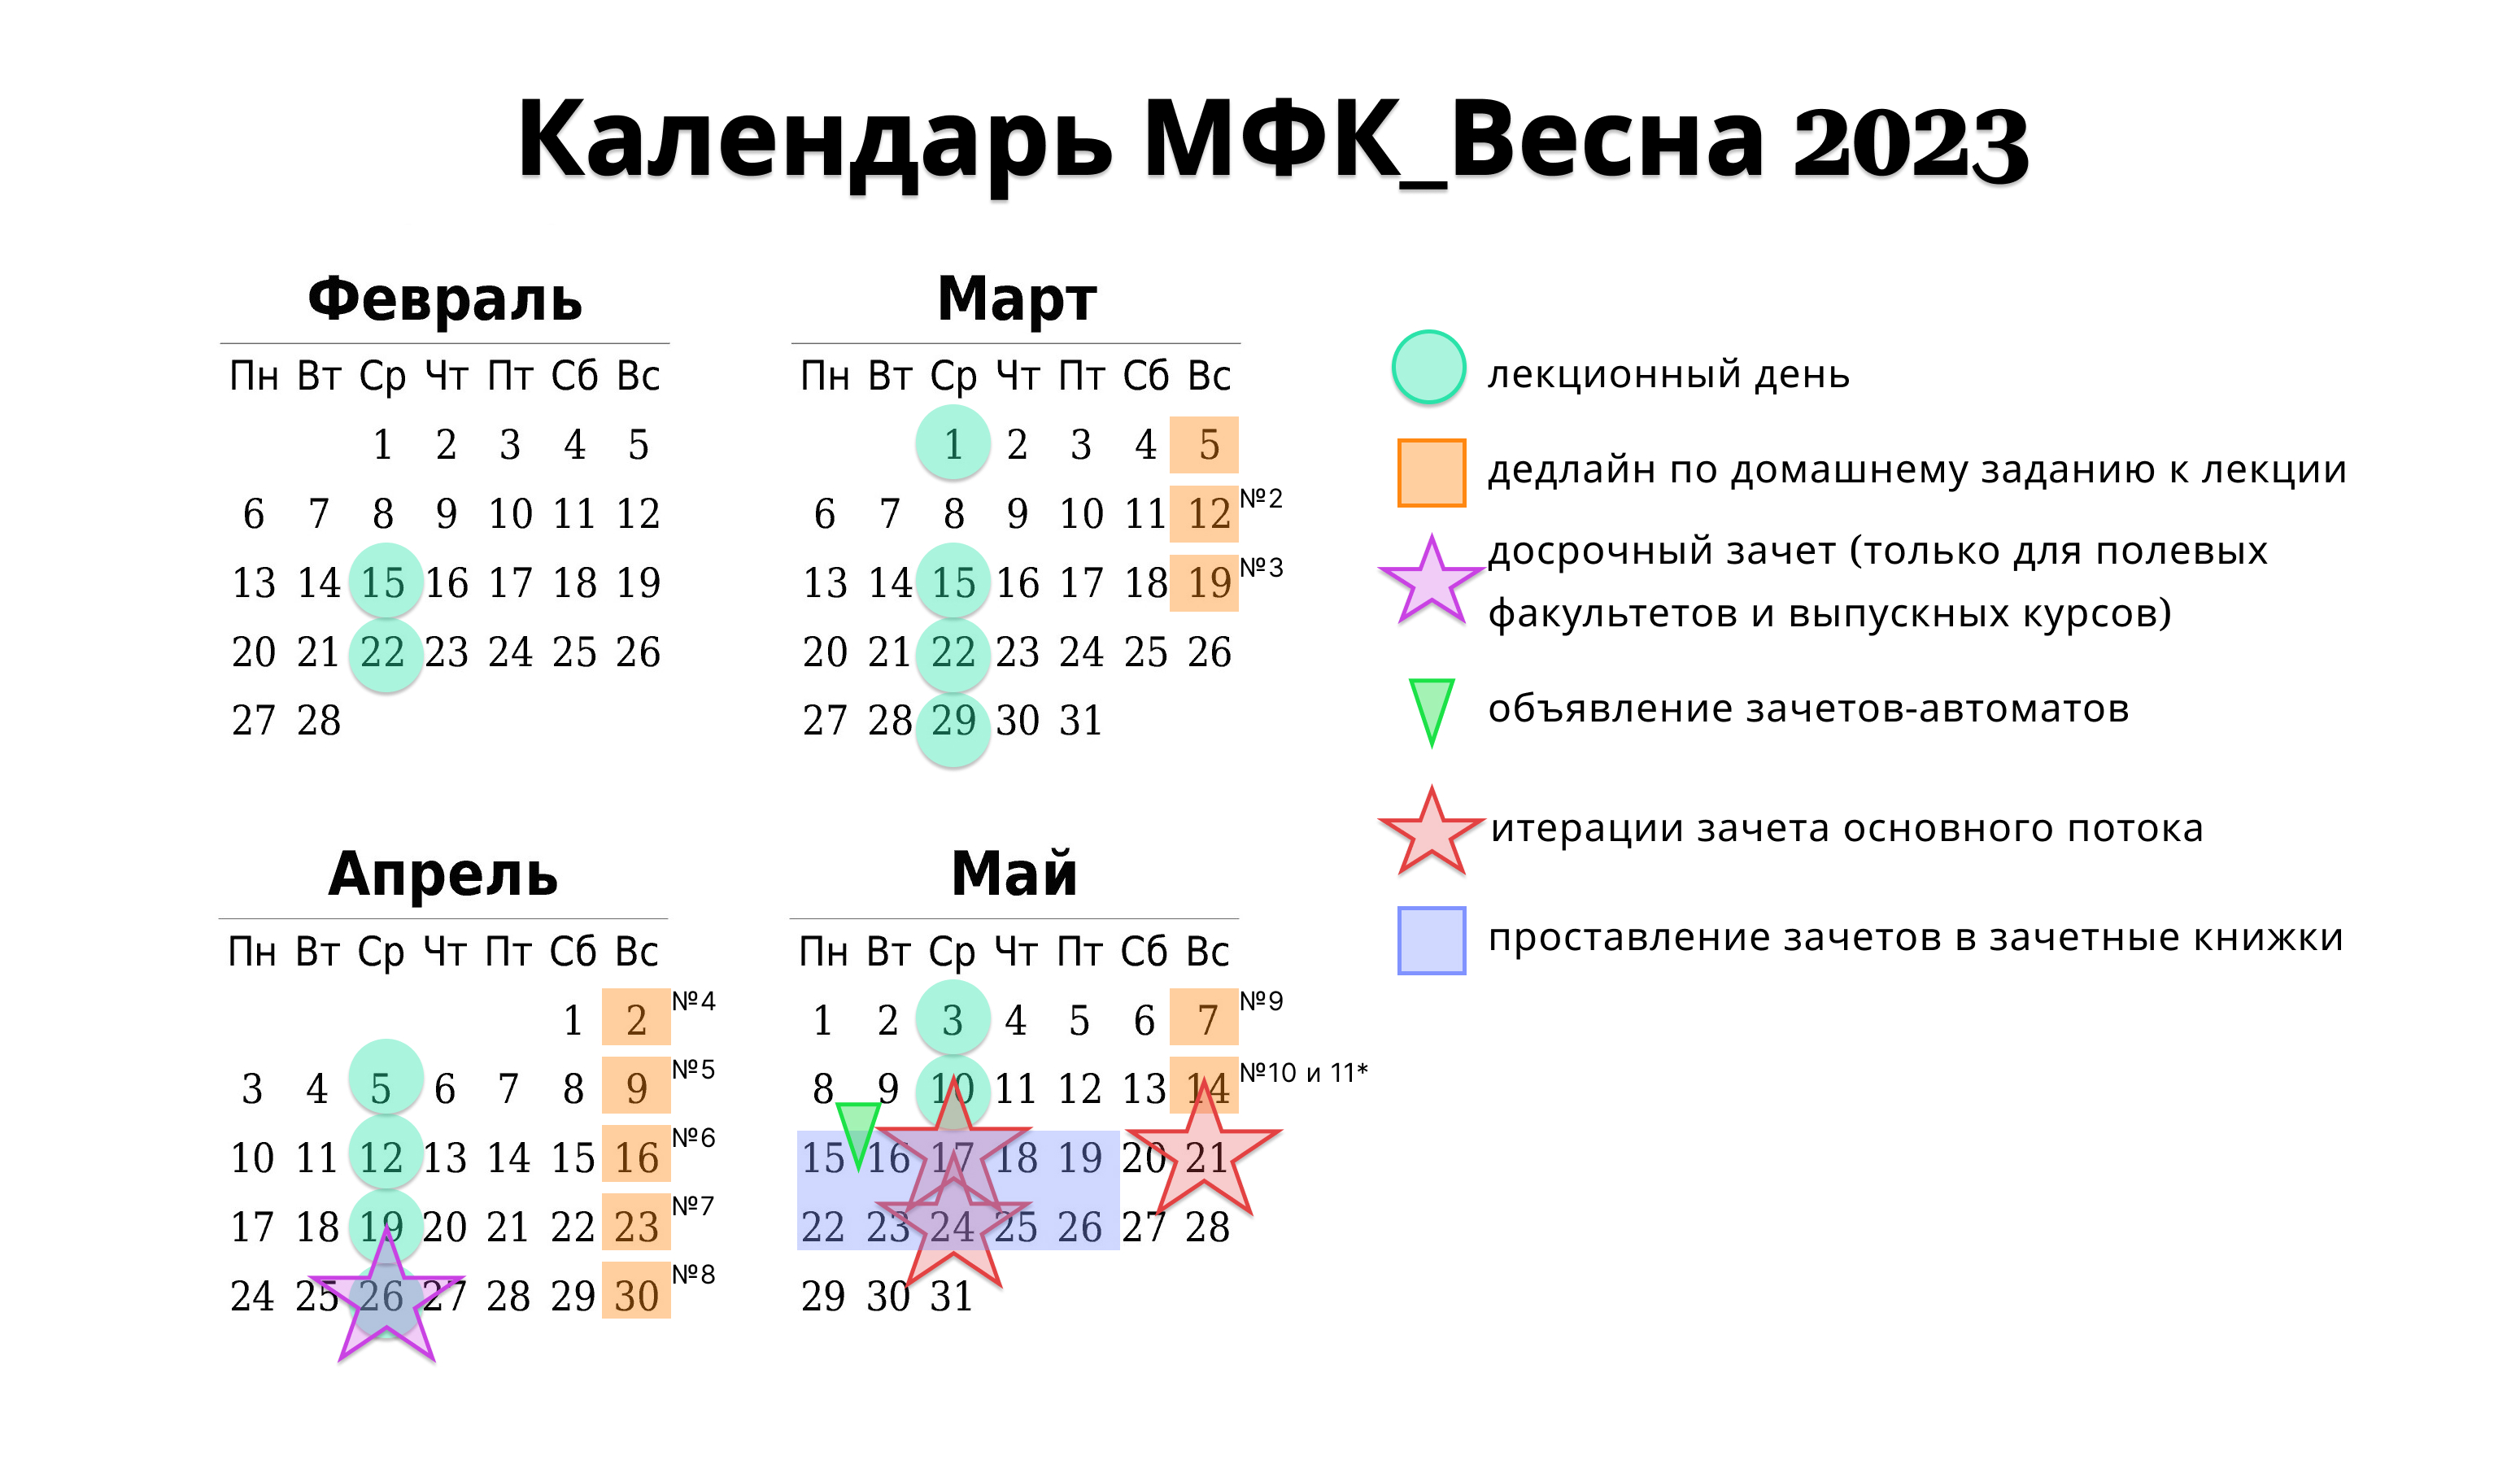